<div style="background-image:url(https://www.datacenterknowledge.com/sites/datacenterknowledge.com/files/styles/article_featured_retina/public/cybersecurity%20security%20infosec%20art%20getty.jpg?itok=9LwGlPRR);background-size:cover;height:400px;color:white;border-radius:20px;">
    <div style="background-color:rgba(125,125,200,0.3);height:400px;border-radius:20px;">
        <br><br>
        <div><h1 style="text-align:center;font-size:50px;">AIC-4101C - Machine learning Project : Malicious and Benign Websites</h1></div>
        <br>
        <div><p style="text-align:center;color:grey;font-style:italic;font-size:30px;">by Raphaël CANIN & Melisa KOCKAN</p></div>
    </div>
    
</div>

# I - Data analysis

Before doing applying any algorithms to the data, we must pre-process it. Indeed, some values are missing, some others are strings or date... Also, maybe some of the columns are not relevant to identify malicious websites.

## A - Data import

Our data is currently stored in a CSV file. We must import this file as an array using Pandas.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

### Read the CSV

In [2]:
csv = pd.read_csv("train.csv")
csv_test = pd.read_csv("test.csv")

### Names of the differents columns

#### Train information

In [3]:
print(csv.columns)
print("Number of columns : ", len(csv.columns))

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')
Number of columns :  21


#### Test information

In [4]:
print(csv_test.columns)
print("Number of columns : ", len(csv_test.columns))

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES'],
      dtype='object')
Number of columns :  20


As explained in the subject, the test dataset does not contain the type column.

### Number of rows

In [5]:
print("Number of rows in train dataset :", len(csv))
print("Number of rows in test dataset :", len(csv_test))

Number of rows in train dataset : 1431
Number of rows in test dataset : 350


## B - Data Visualization & pre-process by column

For each column, we will firstly visualize its content to check if it is relevant to solve our problem. In a second part, we will pre-process the relevant data into meaningful values.

### Last Column : benign or malicious classes

In [6]:
websites_type = csv["Type"]
print(websites_type.head())
print("Length :", len(websites_type))

0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64
Length : 1431


The column "type" contains booleans which inform of the type of the website :
- 0 if it is benign
- 1 if it is malicious

In [7]:
print("Number of benign websites :", len(websites_type.loc[websites_type == 0]))
print("Number of malicious websites :", len(websites_type.loc[websites_type == 1]))

Number of benign websites : 1272
Number of malicious websites : 159


### Column 1 : URL

In [8]:
urls = csv["URL"]
print(urls.head())
print("Length :", len(urls))

0    B0_2314
1     B0_911
2     B0_113
3     B0_403
4    B0_2064
Name: URL, dtype: object
Length : 1431


We notice that there are 2 types of URLs : 
- Type 1 : starts with M0_, M1_ or M4_
- Type 2 : starts with B0_


In [9]:
urls_type = {"M": [], "B0_": []}

for el in urls : 
    if (el.startswith("M")):
        urls_type["M"].append(el)
    elif (el.startswith("B0_")):
         urls_type["B0_"].append(el)
            

    else:
        print("Unknown type")
        print(el)
            
            
print("Length type 1 :",  len(urls_type["M"]) )
print("Length type 2 :",  len(urls_type["B0_"]) )

Length type 1 : 159
Length type 2 : 1272


It seems that the urls starting with M correspond to malicious websites and the ones starting with B are benign websites. Let's check this assumption :

In [10]:
total_malicious = len(csv.loc[(csv["Type"] == 1)])

m_malicious = len(csv.loc[(csv["URL"].str.match('M')) & (csv["Type"] == 1)])
print("% of malicious sites starting with M : ", m_malicious/total_malicious * 100, "%")

m_benign = len(csv.loc[(csv["URL"].str.match('M')) & (csv["Type"] == 0)])
print("% of benign sites starting with M : ", m_benign/total_malicious * 100, "%")

% of malicious sites starting with M :  100.0 %
% of benign sites starting with M :  0.0 %


In [11]:
total_benign = len(csv.loc[(csv["Type"] == 0)])

b_malicious = len(csv.loc[(csv["URL"].str.match('B')) & (csv["Type"] == 1)])
print("% of malicious sites starting with B : ", b_malicious/total_benign * 100, "%")

b_benign = len(csv.loc[(csv["URL"].str.match('B')) & (csv["Type"] == 0)])
print("% of benign sites starting with B out of total benign sites: ", b_benign/total_benign * 100, "%")

% of malicious sites starting with B :  0.0 %
% of benign sites starting with B out of total benign sites:  100.0 %


It is now obvious that the M stands for malicious and B stands for benign. We can write a simple function that predict the website type from its url as following :

In [12]:
def predict_from_url(url):
    if url.startswith("M"):
        return(1) # Malicious
    if url.startswith("B"):
        return(0) # Benign
    return("Prediction is not possible")

Obviously, we will not use this for this project, the URLs where generated according to the website type. In real life, we have real URL and will not be able to use this method. We can however generate the missing column in the test set. Indeed, we do not have the type column in this dataset so we will not be able to compute the accuracy of our models on the test set. 

However, this will only be used at the end of this project to verify our models. We will of course use cross-validation to compute accuracy on the train set only.

In [13]:
test_types = []

for el in csv_test['URL']:
    test_types.append(predict_from_url(el))

csv_test["Type"] = test_types

In [14]:
csv_test.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M4_22,100,20,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1,B0_402,50,11,ISO-8859-1,None,1819.0,US,CA,2/11/2002 0:00,2/02/2017 0:00,...,27,5,5203,41,44,13097,5803,41,8.0,0
2,B0_438,28,7,UTF-8,GSE,6666.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,11,6311,70,64,63634,6633,70,4.0,0
3,B0_759,43,7,UTF-8,GSE,20592.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,13,6081,69,71,63457,6463,69,4.0,0
4,B0_280,47,11,utf-8,Apache/2.2.15 (Red Hat),NaN,None,None,None,None,...,1,7,1552,21,20,2790,2000,21,6.0,0


### One method of data vizualisation : boxplot

An interesting way of vizualising data is to use boxplot. Let's define a function that plot automatically a triple boxplot : 1 global, 1 about benign websites only and the last about malicious websites only.

In [15]:
def auto_boxplot(data, column, showfliers):
    benign = data.loc[csv["Type"]==0][column]
    malicious = data.loc[csv["Type"]==1][column]
   

    plt.figure()
    plt.title("Characteristics of " + column)

    plt.boxplot([data[column], benign, malicious], labels =["Global", "Benign", "Malicious"], showfliers = showfliers)
    plt.show()

#### An example

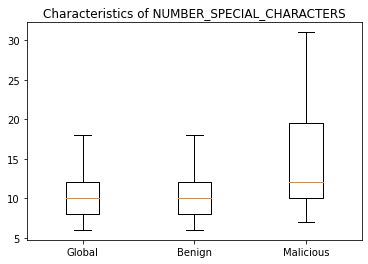

In [16]:
auto_boxplot(csv, "NUMBER_SPECIAL_CHARACTERS", False)

### Detection and correction of outliers

An outlier is a value that is not consistent with other measurements. It is necessary to remove them all because they distort the prediction models. For example, if we want to do a linear regression on the salary of a person according to his level of education, the presence of a billionaire in the data set would distort the trend line.

#### Boxplot method

The boxplot is useful to spot outliers. Indeed, we can display the outliers on it as following :

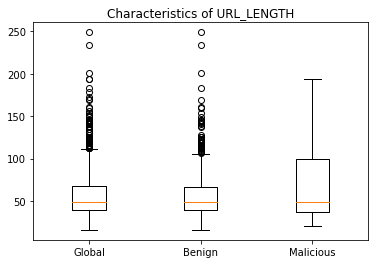

In [17]:
auto_boxplot(csv, "URL_LENGTH", True)

The graph above shows the outliers of the dataset. How are they classified ? It is very simple : a point is considered as an outlier if it is not in the interval : <br><br>
<center>[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]</center>

Let's create a function that automatically correct outliers as following : 

- If it is a <strong>malicious website</strong>, replace the value by the mean of this column of all the malicious websites (without taking the outliers into account).

- If it is a <strong>benign website</strong>, replace the value by the mean of this column of all the benign websites (without taking the outliers into account).

In [18]:

# Returns the input data with all the outliers removed
def data_without_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data.loc[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 *IQR)]  

# returns True if el is an outlier in data
def is_outlier(data, el):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
   
    return (el < Q1 - 1.5 * IQR) or (el > Q3 + 1.5 *IQR)
    

def correct_outliers(csv, column):
    res = csv.copy()
    b = res.loc[csv["Type"] == 0][column]
    m = res.loc[csv["Type"] == 1][column]
    b_without_outliers = data_without_outliers(b)
    m_without_outliers = data_without_outliers(m)
    count = 0
    
    for index, row in res.iterrows():
        is_malicious = (row['Type'] == 1) # True if row corresponds to a malicious website
    
        x = row[column]
        
        if is_malicious:
            if is_outlier(m, x):
                count += 1
                res.at[index,column]= m_without_outliers.mean()
                
        else:
            if is_outlier(b, x):
                count += 1
                res.at[index,column]= b_without_outliers.mean()

    print("Done on", str(column) + ".", count, "outliers processed.")
    return res


Before correction


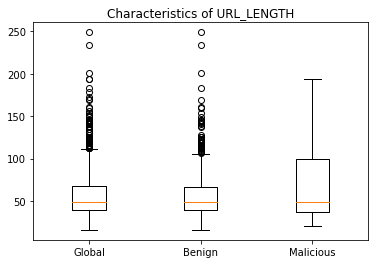

After correction
Done on URL_LENGTH. 48 outliers processed.


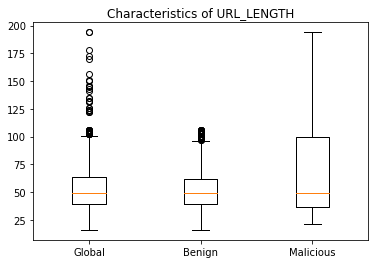

In [19]:
print("Before correction")
auto_boxplot(csv, "URL_LENGTH", True)

print("After correction")
auto_boxplot(correct_outliers(csv, "URL_LENGTH"), "URL_LENGTH", True)

As we can see, we minimized the number of outliers. On the global boxplot, there is still some outliers as we corrected them according to their type. Also, some new outliers have been created on the benign data. Indeed, we modified quite a lot of values and Q1, Q3 and IQR might have been modified. So, some points that where previously on the limit of being outliers are now considered as outliers.

Let's check how much this correction improve the models' accuracy.

In [20]:
# Two simple test models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def KNN_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    
    model = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    
    return model.score(X_test, y_test)

from sklearn.linear_model import LogisticRegression

def LR_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    model = LogisticRegression(random_state=0).fit(X_train, y_train)
    
    return model.score(X_test, y_test)

Let's compute the mean of the accuracy before and after the correction for each model on a certain number of tries (the train test split is random, so the accuracy will slighty change between tries) : 

In [21]:
train = csv["URL_LENGTH"].to_numpy().reshape(-1,1)
train_labels = csv["Type"]
train_after = correct_outliers(csv, "URL_LENGTH")["URL_LENGTH"].to_numpy().reshape(-1,1)

n = 10 # number of tries

KNN_accuracy_before = 0
KNN_accuracy_after  = 0
LR_accuracy_before  = 0
LR_accuracy_after   = 0

for i in range(n):
    KNN_accuracy_before += KNN_accuracy(train, train_labels)
    KNN_accuracy_after  += KNN_accuracy(train_after, train_labels)
    LR_accuracy_before  += LR_accuracy(train, train_labels)
    LR_accuracy_after   += LR_accuracy(train_after, train_labels)
    
print("KNN mean of the accuracy before correction :", KNN_accuracy_before/n)
print("KNN mean of the accuracy after correction  :", KNN_accuracy_after/n)


print("LR mean of the accuracy before correction :", LR_accuracy_before/n)
print("LR mean of the accuracy after correction  :", LR_accuracy_after/n)

Done on URL_LENGTH. 48 outliers processed.
KNN mean of the accuracy before correction : 0.8856236786469346
KNN mean of the accuracy after correction  : 0.9150105708245242
LR mean of the accuracy before correction : 0.8845665961945031
LR mean of the accuracy after correction  : 0.8957716701902749


As we can see, this correction slighty improves the accuracies of our models. It is thus useful.

This method is often used to correct outliers. However, it is not perfect as it doesn't take into account the correlations between columns for example. Let's check another method to correct missing data and outliers at the same time.

#### KNN Impute method

We can also try to process outliers by using KNN to impute data. It estimates values by checking the ones of the k nearest neighbours. To do such things, we must set to NaN the outliers.

In [22]:
def outliers_to_nan(data, column):
    res = data.copy()
    b = res.loc[res["Type"] == 0][column]
    m = res.loc[res["Type"] == 1][column]
    count = 0 
    for index, row in res.iterrows():
        is_malicious = (row['Type'] == 1) # True if row corresponds to a malicious website
    
        x = row[column]
        
        if is_malicious:
            if is_outlier(m, x):
                res.loc[index,column]= np.nan
                count += 1
                
                
        else:
            if is_outlier(b, x):   
                res.loc[index,column]= np.nan
                count += 1
          
    print("Done on", str(column) + ".", count, "outliers processed.")
    return res

Let's apply this function on all the numerical columns :

In [23]:
corrected_data = csv.copy() # Data on which we will apply KNN Imputing
normal_data = csv.copy() # Original Data
from pandas.api.types import is_numeric_dtype

# Numerical columns : 
num_col = []

for el in corrected_data.columns:
    if is_numeric_dtype(corrected_data[el]):
        num_col.append(el)
        
for el in num_col:
    if (el != "Type"):
        corrected_data = outliers_to_nan(corrected_data, el)

Done on URL_LENGTH. 48 outliers processed.
Done on NUMBER_SPECIAL_CHARACTERS. 68 outliers processed.
Done on CONTENT_LENGTH. 88 outliers processed.
Done on TCP_CONVERSATION_EXCHANGE. 67 outliers processed.
Done on DIST_REMOTE_TCP_PORT. 143 outliers processed.
Done on REMOTE_IPS. 18 outliers processed.
Done on APP_BYTES. 71 outliers processed.
Done on SOURCE_APP_PACKETS. 61 outliers processed.
Done on REMOTE_APP_PACKETS. 66 outliers processed.
Done on SOURCE_APP_BYTES. 217 outliers processed.
Done on REMOTE_APP_BYTES. 60 outliers processed.
Done on APP_PACKETS. 61 outliers processed.
Done on DNS_QUERY_TIMES. 10 outliers processed.


We now can use KNNImputer from SKlearn to complete the NaN in our new dataset.

In [24]:
from sklearn.impute import KNNImputer


# start the KNN training
model = KNNImputer(n_neighbors = 10,weights="uniform").fit(corrected_data[num_col])
new_data = model.fit_transform(corrected_data[num_col])
new_data = pd.DataFrame(new_data,columns=num_col)

for el in num_col:
    corrected_data[el] = new_data[el]

In [25]:
train = normal_data["URL_LENGTH"].to_numpy().reshape(-1,1)
train_labels = csv["Type"]
train_after_knn = corrected_data["URL_LENGTH"].to_numpy().reshape(-1,1)
train_after_mean = correct_outliers(csv, "URL_LENGTH")["URL_LENGTH"].to_numpy().reshape(-1,1)

n = 30 # number of tries

KNN_accuracy_before = 0
KNN_accuracy_after_knn  = 0
LR_accuracy_before  = 0
LR_accuracy_after_knn   = 0
KNN_accuracy_after_mean = 0
LR_accuracy_after_mean = 0

for i in range(n):
    KNN_accuracy_before += KNN_accuracy(train, train_labels)
    KNN_accuracy_after_knn  += KNN_accuracy(train_after_knn, train_labels)
    KNN_accuracy_after_mean  += KNN_accuracy(train_after_mean, train_labels)
    LR_accuracy_before  += LR_accuracy(train, train_labels)
    LR_accuracy_after_knn   += LR_accuracy(train_after_knn, train_labels)
    LR_accuracy_after_mean   += LR_accuracy(train_after_mean, train_labels)
    
print("KNN mean of the accuracy before      correction :", KNN_accuracy_before/n)
print("KNN mean of the accuracy after  mean correction :", KNN_accuracy_after_mean/n)
print("KNN mean of the accuracy after  KNN  correction :", KNN_accuracy_after_knn/n)



print("LR  mean of the accuracy before      correction :", LR_accuracy_before/n)
print("LR  mean of the accuracy after  mean correction :", LR_accuracy_after_mean/n)
print("LR  mean of the accuracy after  KNN  correction :", LR_accuracy_after_knn/n)

Done on URL_LENGTH. 48 outliers processed.
KNN mean of the accuracy before      correction : 0.8909090909090912
KNN mean of the accuracy after  mean correction : 0.9141649048625793
KNN mean of the accuracy after  KNN  correction : 0.9145877378435519
LR  mean of the accuracy before      correction : 0.8885835095137421
LR  mean of the accuracy after  mean correction : 0.8982381959126147
LR  mean of the accuracy after  KNN  correction : 0.8933051444679353


As we can see, KNN Imputation does not improve our outliers correction. We will thus use the mean to correct our outliers. Let's define our new dataset using this method.

In [26]:
data = csv.copy() # Data on which we will apply mean correction

from pandas.api.types import is_numeric_dtype

# Numerical columns : 
num_col = []

# Getting the numerical columns
for el in data.columns:
    if is_numeric_dtype(data[el]):
        num_col.append(el)
        
for el in num_col:
    if (el != "Type"):
        data = correct_outliers(data, el)   

Done on URL_LENGTH. 48 outliers processed.
Done on NUMBER_SPECIAL_CHARACTERS. 68 outliers processed.
Done on CONTENT_LENGTH. 88 outliers processed.
Done on TCP_CONVERSATION_EXCHANGE. 67 outliers processed.
Done on DIST_REMOTE_TCP_PORT. 143 outliers processed.
Done on REMOTE_IPS. 18 outliers processed.
Done on APP_BYTES. 71 outliers processed.
Done on SOURCE_APP_PACKETS. 61 outliers processed.
Done on REMOTE_APP_PACKETS. 66 outliers processed.
Done on SOURCE_APP_BYTES. 217 outliers processed.
Done on REMOTE_APP_BYTES. 60 outliers processed.
Done on APP_PACKETS. 61 outliers processed.
Done on DNS_QUERY_TIMES. 10 outliers processed.


In [27]:
data

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.000000,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.000000,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
2,B0_113,17,6,ISO-8859-1,nginx,162.000000,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,UTF-8,None,5305.320635,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1427,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1428,B0_162,52,10,utf-8,Apache/2.2.16 (Debian),8904.000000,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,ISO-8859-1,cloudflare-nginx,NaN,US,CA,1/04/1998 0:00,9/12/2016 0:00,...,0,0,0,0,0,0,0,0,0.0,0


### Missing data

Sometimes, some values are missing (NaN or 0) in the dataset. We then get three choices (not exhaustive) : 

- Removing the entire row. It is not optimal as we can lose a lot of data quite fast. 

- Replacing the value by the mean of the column. It is the method we use above. This is still a rather archaic method that takes only one column into account to modify the values.

- Using a imputing model. It estimates the missing values. 

Let's check that last method.

In [28]:
import math
def correct_missing(data, column, change_zeros = True):
    res = data.copy()
    b = res.loc[(res["Type"] == 0)][column]
    m = res.loc[(res["Type"] == 1)][column]

    count_m = 0
    count_b = 0
    
    for index, row in res.iterrows():
        is_malicious = (row['Type'] == 1) # True if row corresponds to a malicious website
    
        x = row[column]
        
        if is_malicious:
            if math.isnan(x) or (x==0 and change_zeros):
                count_b += 1
                res.at[index,column]= np.floor(m.mean())
                
        else:
            if math.isnan(x) or (x==0 and change_zeros):
                count_m += 1
                res.at[index,column]= np.floor(b.mean())

    print("Done on", str(column) + ".", count_m, "malicious and", count_b, "benign missing processed.")
    return res


In [29]:
correct_missing(data, "CONTENT_LENGTH")

Done on CONTENT_LENGTH. 568 malicious and 80 benign missing processed.


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.000000,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.000000,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
2,B0_113,17,6,ISO-8859-1,nginx,162.000000,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,UTF-8,None,5305.320635,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,UTF-8,nginx,5305.000000,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,UTF-8,Apache,970.000000,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1427,M4_48,194,16,UTF-8,Apache,970.000000,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1428,B0_162,52,10,utf-8,Apache/2.2.16 (Debian),8904.000000,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,ISO-8859-1,cloudflare-nginx,5305.000000,US,CA,1/04/1998 0:00,9/12/2016 0:00,...,0,0,0,0,0,0,0,0,0.0,0


In [30]:
mod_nan_data = data.copy() # Data on which we will apply mean correction

from pandas.api.types import is_numeric_dtype

# Numerical columns : 
num_col = []

# Getting the numerical columns
for el in data.columns:
    if is_numeric_dtype(data[el]):
        num_col.append(el)
        
for el in num_col:
    if (el == "DNS_QUERY_TIMES"):
        mod_nan_data = correct_missing(mod_nan_data, el, change_zeros = False) 
        
    elif (el != "Type"):
        mod_nan_data = correct_missing(mod_nan_data, el)   
        

Done on URL_LENGTH. 0 malicious and 0 benign missing processed.
Done on NUMBER_SPECIAL_CHARACTERS. 0 malicious and 0 benign missing processed.
Done on CONTENT_LENGTH. 568 malicious and 80 benign missing processed.
Done on TCP_CONVERSATION_EXCHANGE. 476 malicious and 41 benign missing processed.
Done on DIST_REMOTE_TCP_PORT. 616 malicious and 120 benign missing processed.
Done on REMOTE_IPS. 476 malicious and 41 benign missing processed.
Done on APP_BYTES. 476 malicious and 41 benign missing processed.
Done on SOURCE_APP_PACKETS. 476 malicious and 41 benign missing processed.
Done on REMOTE_APP_PACKETS. 474 malicious and 0 benign missing processed.
Done on SOURCE_APP_BYTES. 474 malicious and 0 benign missing processed.
Done on REMOTE_APP_BYTES. 476 malicious and 41 benign missing processed.
Done on APP_PACKETS. 476 malicious and 41 benign missing processed.
Done on DNS_QUERY_TIMES. 1 malicious and 0 benign missing processed.


In [31]:
mod_nan_data.isna().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       1
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

We now have a dataset without NaN or 0 in numerical fields.

In [32]:
train = data.dropna()["CONTENT_LENGTH"].to_numpy().reshape(-1,1)
train_labels = data.dropna()["Type"]
train_after_unnan = mod_nan_data["CONTENT_LENGTH"].to_numpy().reshape(-1,1)
train_labels_unnan = mod_nan_data["Type"]

n = 30 # number of tries

KNN_accuracy_before = 0
KNN_accuracy_after  = 0
LR_accuracy_before  = 0
LR_accuracy_after   = 0


for i in range(n):
    KNN_accuracy_before += KNN_accuracy(train, train_labels)
    KNN_accuracy_after  += KNN_accuracy(train_after_unnan, train_labels_unnan)
  
    LR_accuracy_before  += LR_accuracy(train, train_labels)
    LR_accuracy_after   += LR_accuracy(train_after_unnan, train_labels_unnan)
   
    
print("KNN mean of the accuracy after nan suppression :", KNN_accuracy_before/n)
print("KNN mean of the accuracy after nan correction  :", KNN_accuracy_after/n)



print("LR  mean of the accuracy after nan suppression :", LR_accuracy_before/n)
print("LR  mean of the accuracy after nan correction  :", KNN_accuracy_after/n)


KNN mean of the accuracy after nan suppression : 0.9297297297297298
KNN mean of the accuracy after nan correction  : 0.9638477801268496
LR  mean of the accuracy after nan suppression : 0.8978120978120979
LR  mean of the accuracy after nan correction  : 0.9638477801268496


This method is clearly better than just deleting the rows with NaN values. Let's define our new dataset for the rest of the project : 

In [33]:
data = mod_nan_data.copy()

### Study of the categorical columns

In [34]:
mod_nan_data = data.copy() # Data on which we will replace all the None of our categorical columns

# Visualizing all the categorical columns
cat_col = []
for el in data.columns:
    if is_numeric_dtype(data[el])==False:
        cat_col.append(el)  
print(cat_col)


['URL', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']


For each categorical column, we are going to replace the None by the most frequent value
However, since our data contains a majority of benign website, we are going to calculate the most frequent value for the malicious website and another one for the benign websites.

In [35]:
""" The function below returns, for a given categorical column, the list of the most repeated value 
for the benin and for the malicious websites"""
def mostrepeated(data, column,n):
    res = data.copy()
    b = res.loc[res["Type"] == 0][column]
    m = res.loc[res["Type"] == 1][column]
    benin=b.value_counts()[:n].index.tolist()
    malice=m.value_counts()[:n].index.tolist()
    return benin,malice
   
""" The function below replaces the None of a column for which we calculated the most repeated value 
beforehand thanks to the previous function"""
def correct_None(data, column,benin,malice):
    count_b = 0
    count_m = 0
    if(benin[0]=='None' or benin[0]=='none'):
        most_freq_benin=benin[1]
    else:
        most_freq_benin=benin[0]
    
    if(malice[0]=='None' or benin[1]=='none'):
        most_freq_malice=malice[1]
    else:
        most_freq_malice=malice[0]
    
    for index, row in data.iterrows():
        is_malicious = (row['Type'] == 1) # True if row corresponds to a malicious website
        x = row[column]
        
        if is_malicious:
            if x=='None'or x=='none':
                count_m += 1
                data.at[index,column]= most_freq_malice
            elif type(x)==type(1.0):
                if math.isnan(x):
                    count_m += 1
                    data.at[index,column]= most_freq_malice
        else:
            if x=='None' or x=='none':
                count_b += 1
                data.at[index,column]= most_freq_benin
                
            elif type(x)==type(1.0):
                if math.isnan(x):
                    count_b += 1
                    data.at[index,column]= most_freq_benin
    print("Done on ", str(column) + ".", count_m, "malicious and", count_b, "benign None processed." )
    return data

###### However, we need to preprocess each column before using these two methods !

### Column Server

Let's take a look at this column

In [36]:
Server = data["SERVER"].copy()
print(Server)

0                Apache/2.4.10
1        Microsoft-HTTPAPI/2.0
2                        nginx
3                         None
4                        nginx
                 ...          
1426                    Apache
1427                    Apache
1428    Apache/2.2.16 (Debian)
1429          cloudflare-nginx
1430         Microsoft-IIS/8.5
Name: SERVER, Length: 1431, dtype: object


Let's create a function named columnserver which will preprocess the server column
by visualizing our column's data, we see that a lot of server are repeated but not with the same version ; however, this criteria didn't seem relevant to keep. 

In [37]:
def columnserver(data):
    for index, row in data.iterrows():
            x = row['SERVER']
            if(type(x) is str):# we're checking because we had a float exception value
                divided=x.split('/') #we've noticed that most of the versions are given after using /
                data.at[index,'SERVER']=divided[0] # so we split the string and only keep the name
                
                dividedpoint=x.split('.') # for one of the outliers, the version was given after a .
                if(len(dividedpoint)>1):
                    if(dividedpoint[1]=="codfw"):
                        data.at[index,'SERVER']="codfw"
    return data

#Taking a look at what we have done so far
columnserver(mod_nan_data)
print(data['SERVER'].head)
print("")
print(mod_nan_data['SERVER'].head)

<bound method NDFrame.head of 0                Apache/2.4.10
1        Microsoft-HTTPAPI/2.0
2                        nginx
3                         None
4                        nginx
                 ...          
1426                    Apache
1427                    Apache
1428    Apache/2.2.16 (Debian)
1429          cloudflare-nginx
1430         Microsoft-IIS/8.5
Name: SERVER, Length: 1431, dtype: object>

<bound method NDFrame.head of 0                  Apache
1       Microsoft-HTTPAPI
2                   nginx
3                    None
4                   nginx
              ...        
1426               Apache
1427               Apache
1428               Apache
1429     cloudflare-nginx
1430        Microsoft-IIS
Name: SERVER, Length: 1431, dtype: object>


In [38]:
benin,malice = mostrepeated(mod_nan_data,'SERVER',25)
print(benin)
print(malice)

['Apache', 'nginx', 'None', 'Microsoft-HTTPAPI', 'cloudflare-nginx', 'codfw', 'Microsoft-IIS', 'GSE', 'Server', 'YouTubeFrontEnd', 'ATS', 'Apache-Coyote', 'openresty', 'LiteSpeed', 'Varnish', 'ebay server', 'AmazonS3', 'Jetty(9.0.z-SNAPSHOT)', 'nginx + Phusion Passenger', 'Pizza', 'DMS', 'Pagely Gateway', 'AkamaiGHost', 'Squeegit', 'squid']
['Apache', 'nginx', 'Microsoft-IIS', 'cloudflare-nginx', 'Microsoft-HTTPAPI', 'Proxy Pandeiro UOL', 'DOSarrest', 'lighttpd', 'PWS', 'nxfps', 'marrakesh 1.12.2']


The versions details disappeared, we can now replace all the None of the Server column

In [39]:
mod_nan_data = correct_None(mod_nan_data, 'SERVER', benin, malice) 
mod_nan_data['SERVER'].head

Done on  SERVER. 0 malicious and 129 benign None processed.


<bound method NDFrame.head of 0                  Apache
1       Microsoft-HTTPAPI
2                   nginx
3                  Apache
4                   nginx
              ...        
1426               Apache
1427               Apache
1428               Apache
1429     cloudflare-nginx
1430        Microsoft-IIS
Name: SERVER, Length: 1431, dtype: object>

In [40]:
mod_nan_data['SERVER'].value_counts()

Apache               641
nginx                263
Microsoft-HTTPAPI     92
cloudflare-nginx      68
Microsoft-IIS         66
                    ... 
ECD (fll               1
fbs                    1
gunicorn               1
PWS                    1
IdeaWebServer          1
Name: SERVER, Length: 66, dtype: int64

### Column Charset

Let's display all the differents values of this column

In [41]:
charsets = data["CHARSET"].copy()
print(charsets.head())
print("Length :", len(charsets))

0         UTF-8
1      us-ascii
2    ISO-8859-1
3         UTF-8
4         UTF-8
Name: CHARSET, dtype: object
Length : 1431


As we can see, some of the values are similar but are spelled differently (UTF-8 and utf-8, for example).


In [42]:
mod_nan_data['CHARSET'].value_counts()

UTF-8           540
ISO-8859-1      350
utf-8           297
us-ascii        124
iso-8859-1      111
None              6
windows-1251      1
ISO-8859          1
windows-1252      1
Name: CHARSET, dtype: int64

We also have outliers and missing values : 
- none
- windows-1252
- windows-1251

Let's create a function named columncharset which will preprocess the charset column.
This function will lower all the charset and prevent the use of different names for a same value

In [43]:
def columncharset(data):
    for index, row in data.iterrows():
            x = row['CHARSET']
            if(type(x) is str):
                if(x.lower()=="iso-8859-1"):
                    data.at[index,'CHARSET']="iso-8859"
                elif(x.lower()=="windows-1251" or x.lower()=="windows-1252"):
                    data.at[index,'CHARSET']="none" 
                    #To treat the case of this outlier, we treat it as a none value
                elif(type(x)==type(1.0)):
                    if math.isnan(x):
                        data.at[index,'CHARSET']="none"
                else:
                    data.at[index,'CHARSET']=x.lower()#to lower the string

    return data
        
columncharset(mod_nan_data)
mod_nan_data['CHARSET'].value_counts()

utf-8       837
iso-8859    462
us-ascii    124
none          8
Name: CHARSET, dtype: int64

In [44]:
#most repeated values for benign and malicious website
benin,malice=mostrepeated(mod_nan_data,'CHARSET',25)
print(benin)
print(malice)

['utf-8', 'iso-8859', 'us-ascii', 'none']
['utf-8', 'iso-8859', 'us-ascii', 'none']


We can now replace all the None

In [45]:
mod_nan_data = correct_None(mod_nan_data, 'CHARSET', benin, malice) 

Done on  CHARSET. 2 malicious and 6 benign None processed.


In [46]:
mod_nan_data['CHARSET'].value_counts()

utf-8       845
iso-8859    462
us-ascii    124
Name: CHARSET, dtype: int64

As we can see, the values are spread evenly between benign and malicious websites. It seems that this column does not give crucial information. We can ignore it.

In [47]:
data = mod_nan_data.copy()

### Country column

In [48]:
Countries = data["WHOIS_COUNTRY"].copy()
print(Countries.head())
print("Length :", len(charsets))

0    None
1    None
2      US
3      US
4      SC
Name: WHOIS_COUNTRY, dtype: object
Length : 1431


In [49]:
Countries.value_counts()

US                896
None              211
CA                 76
ES                 42
AU                 30
GB                 17
PA                 15
JP                 11
CN                 10
IN                 10
CZ                  8
UK                  8
NL                  6
CH                  6
FR                  6
[u'GB'; u'UK']      5
KR                  5
ru                  4
PH                  4
BS                  4
AT                  4
us                  3
TR                  3
HK                  3
BE                  3
DE                  3
KY                  3
SE                  3
SC                  3
UA                  2
Cyprus              2
UY                  2
KG                  2
BR                  2
NO                  2
IL                  2
SI                  2
RU                  2
LU                  1
LV                  1
United Kingdom      1
PK                  1
IT                  1
se                  1
BY                  1
AE        

The preprocessing function columncountries replaces the outlier United Kingdom by UK, uppers every string to keep the same format, and treats the case "[u'GB'; u'UK']" by replacing it either by UK or by GB with a probability of 1/2 for each 

In [50]:
def columncountries(data):
    res = data.copy()
    for index, row in res.iterrows():
            x = row['WHOIS_COUNTRY']
            if(type(x) is str):
                if(x=='United Kingdom'):  
                    x='UK'
                    res.at[index,'WHOIS_COUNTRY']=x

                elif("""[u'GB'; u'UK']""" in x):
                
                    pb=np.random.randint(1,2)
                    if(pb==1):
                        res.at[index,'WHOIS_COUNTRY']='UK'
                    else:
                        res.at[index,'WHOIS_COUNTRY']='GB'
                    
                if(x!='None'):
                    res.at[index,'WHOIS_COUNTRY'] = res.at[index,'WHOIS_COUNTRY'].upper()
           
    return res
        
new_data = columncountries(data)
new_data['WHOIS_COUNTRY'].value_counts()

US        899
None      211
CA         76
ES         42
AU         30
GB         17
PA         15
UK         14
JP         11
CN         10
IN         10
CZ          8
FR          6
NL          6
CH          6
RU          6
KR          5
AT          4
BS          4
PH          4
SE          4
KY          3
TR          3
SC          3
DE          3
HK          3
BE          3
SI          2
UA          2
UY          2
CYPRUS      2
NO          2
KG          2
IL          2
BR          2
LU          1
TH          1
PK          1
IT          1
BY          1
AE          1
IE          1
UG          1
LV          1
Name: WHOIS_COUNTRY, dtype: int64

In [51]:
benin,malice = mostrepeated(new_data,'WHOIS_COUNTRY',25)
print(benin)
print(malice)

['US', 'None', 'CA', 'AU', 'PA', 'GB', 'UK', 'JP', 'IN', 'CN', 'CH', 'NL', 'FR', 'AT', 'BS', 'PH', 'SE', 'KY', 'SC', 'BE', 'TR', 'HK', 'KR', 'IL', 'CYPRUS']
['ES', 'None', 'US', 'CZ', 'RU', 'GB', 'CN', 'CA', 'BR', 'PA', 'KR', 'UA', 'UY', 'UG', 'IN', 'FR', 'PK', 'DE', 'UK']


We can now replace all our None values

In [52]:
new_data = correct_None(new_data, 'WHOIS_COUNTRY', benin, malice) 

Done on  WHOIS_COUNTRY. 40 malicious and 171 benign None processed.


In [53]:
new_data['WHOIS_COUNTRY'].value_counts()

US        1070
ES          82
CA          76
AU          30
GB          17
PA          15
UK          14
JP          11
CN          10
IN          10
CZ           8
NL           6
CH           6
RU           6
FR           6
KR           5
BS           4
PH           4
AT           4
SE           4
KY           3
SC           3
BE           3
TR           3
HK           3
DE           3
CYPRUS       2
UY           2
UA           2
KG           2
BR           2
NO           2
IL           2
SI           2
LU           1
LV           1
PK           1
IT           1
BY           1
AE           1
IE           1
UG           1
TH           1
Name: WHOIS_COUNTRY, dtype: int64

In [54]:
new_data.loc[new_data['Type'] == 1 ]["WHOIS_COUNTRY"].value_counts()

ES    81
US    40
CZ     7
RU     6
GB     4
CN     3
BR     2
UA     2
KR     2
PA     2
UY     2
CA     2
FR     1
UG     1
IN     1
PK     1
DE     1
UK     1
Name: WHOIS_COUNTRY, dtype: int64

In [55]:
data = new_data.copy()

### Statepro column

In [56]:
Statepro = data["WHOIS_STATEPRO"].copy()
print(Statepro.head())
print("Length :", len(Statepro))

0    None
1    None
2      AK
3      TX
4    Mahe
Name: WHOIS_STATEPRO, dtype: object
Length : 1431


In [57]:
Statepro.value_counts()

CA            301
None          260
NY             64
Arizona        51
FL             50
             ... 
Vic             1
New Jersey      1
Alicante        1
SK              1
Paris           1
Name: WHOIS_STATEPRO, Length: 182, dtype: int64

For this preprocessing function, we only upper every state to prevent the use of different format for a same state

In [58]:
def columnstatepro(data):
    res = data.copy()
    for index, row in res.iterrows():
            x = row['WHOIS_STATEPRO']
            if(type(x) is str):
                if(x!='None'):
                    res.at[index,'WHOIS_STATEPRO']=x.upper()
    return res
        
columnstatepro(data)
data['WHOIS_STATEPRO'].value_counts()

CA            301
None          260
NY             64
Arizona        51
FL             50
             ... 
Vic             1
New Jersey      1
Alicante        1
SK              1
Paris           1
Name: WHOIS_STATEPRO, Length: 182, dtype: int64

In [59]:
benin,malice=mostrepeated(data,'WHOIS_STATEPRO',25)
print(benin)
print(malice)

['CA', 'None', 'NY', 'Arizona', 'FL', 'WA', 'ON', 'California', 'UT', 'NV', 'CO', 'IL', 'PA', 'MA', 'MO', 'NJ', 'PANAMA', 'Ohio', 'TX', 'Queensland', 'New York', 'VA', 'Texas', 'UK', 'GA']
['None', 'Barcelona', 'California', 'Utah', 'PRAHA', 'WC1N', 'Krasnoyarsk', 'PA', 'Washington', 'Montevideo', 'WA', 'PANAMA', 'Arizona', 'ON', 'CA', 'MD', 'MOSCOW', 'Massachusetts', 'FL', 'AZ', 'MA', 'UTAH', 'Punjab', 'ALABAMA', 'Bei Jing']


We can now replace all our None value

In [60]:
new_data = correct_None(data, 'WHOIS_STATEPRO', benin, malice) 

Done on  WHOIS_STATEPRO. 47 malicious and 213 benign None processed.


In [61]:
new_data['WHOIS_STATEPRO'].value_counts()

CA                 514
Barcelona           88
NY                  64
Arizona             51
FL                  50
                  ... 
Peterborough         1
6110021              1
NEW SOUTH WALES      1
Indiana              1
Paris                1
Name: WHOIS_STATEPRO, Length: 181, dtype: int64

In [62]:
new_data

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,utf-8,Apache,15087.000000,US,CA,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,us-ascii,Microsoft-HTTPAPI,324.000000,US,CA,None,None,...,2,2,1237,13,13,3524,1436,13,0.0,0
2,B0_113,17,6,iso-8859,nginx,162.000000,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,utf-8,Apache,5305.320635,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,utf-8,nginx,5305.000000,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,utf-8,Apache,970.000000,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,2,1257,14,3,186,1470,14,0.0,1
1427,M4_48,194,16,utf-8,Apache,970.000000,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,2,1257,14,3,186,1470,14,0.0,1
1428,B0_162,52,10,utf-8,Apache,8904.000000,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,iso-8859,cloudflare-nginx,5305.000000,US,CA,1/04/1998 0:00,9/12/2016 0:00,...,2,2,1237,13,13,3524,1436,13,0.0,0


### Column 2 : URL_LENGTH

In [63]:
url_lengths = data["URL_LENGTH"].copy()
print(url_lengths.head())
print("Length :", len(url_lengths))

0    16
1    16
2    17
3    17
4    18
Name: URL_LENGTH, dtype: int64
Length : 1431


In [64]:
print(url_lengths.describe())

count    1431.000000
mean       53.990915
std        22.773265
min        16.000000
25%        39.000000
50%        49.000000
75%        64.000000
max       194.000000
Name: URL_LENGTH, dtype: float64


Let's see if there are some major differences between an url length from a malicious website and one from a benign website.

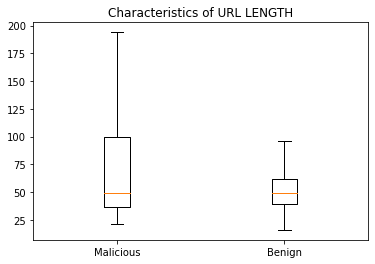

In [65]:
url_len_m = data.loc[csv["Type"]==1]["URL_LENGTH"] # Malicious url lengths
url_len_b = data.loc[csv["Type"]==0]["URL_LENGTH"] # Benign url lengths

plt.figure()
plt.title("Characteristics of URL LENGTH")

plt.boxplot([url_len_m, url_len_b], labels =["Malicious", "Benign"], showfliers = False)
plt.show()

### Column 3 : NUMBER_SPECIAL_CHARACTERS

In [66]:
spec_chars = data["NUMBER_SPECIAL_CHARACTERS"].copy()
print(spec_chars.head())
print("Length :", len(spec_chars))

0    6
1    6
2    6
3    6
4    7
Name: NUMBER_SPECIAL_CHARACTERS, dtype: int64
Length : 1431


In [67]:
print(spec_chars.describe())

count    1431.000000
mean       10.462614
std         3.536399
min         6.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        31.000000
Name: NUMBER_SPECIAL_CHARACTERS, dtype: float64


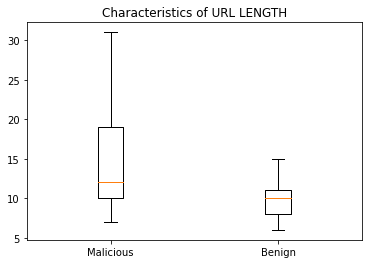

In [68]:
spec_chars_m = data.loc[csv["Type"]==1]["NUMBER_SPECIAL_CHARACTERS"] # Malicious url lengths
spec_chars_b = data.loc[csv["Type"]==0]["NUMBER_SPECIAL_CHARACTERS"] # Benign url lengths

plt.figure()
plt.title("Characteristics of URL LENGTH")

plt.boxplot([spec_chars_m, spec_chars_b], labels =["Malicious", "Benign"], showfliers = False)
plt.show()


There is some obvious differences between the malicious and benign data, this column will be useful.

### Columns 9 & 10 : WHOIS_...DATE

WHOIS is an internet protocol that allows to obtain some information on a server, such as the registration date (WHOIS_REGDATE) or the last update (WHOIS_UPDATED_DATE).

WHOIS_REGDATE and WHOIS_UPDATED_DATE are dates. There are not numerical data or categorical data for now. The best option is to convert these date into a timestamp which represents the number of seconds elapsed since January 1, 1970 (start of Unix time). We will thus get for each date a numerical value that we will be abke to process.

In [69]:
# Function to convert a date in a float 

from datetime import datetime
import pandas as pd
from dateutil import parser

def date2float(date_string):
    try:
        
        date2 = parser.parse(date_string)

        return date2.timestamp()

    except ValueError:
        return 0.0

# To obtain the hours from a date
def date2hours(date_string):
    try:
        date2 = parser.parse(date_string)
        return date2.hour + date2.minute/60
    except ValueError:
        return 0.0

In [70]:
dates = data[["WHOIS_REGDATE", "WHOIS_UPDATED_DATE"]].copy()
print(dates.head())
print("Length :", len(dates))

     WHOIS_REGDATE WHOIS_UPDATED_DATE
0             None               None
1             None               None
2   7/10/1997 4:00    12/09/2013 0:45
3  12/05/1996 0:00    11/04/2017 0:00
4  3/08/2016 14:30     3/10/2016 3:45
Length : 1431


For each row, we convert the date into a float. If it None, we put 0.0 as value.

In [71]:
mod_date = data.copy() # Data on which we will replace all the None

for index, row in dates.iterrows():
    x = row["WHOIS_REGDATE"]
    if x!="None":
        mod_date.loc[index, "WHOIS_REGDATE"] = date2float(x)
    else:
        mod_date.loc[index, "WHOIS_REGDATE"] = 0.0
        
    x = row["WHOIS_UPDATED_DATE"]
    if x!="None":
        mod_date.loc[index, "WHOIS_UPDATED_DATE"] = date2float(x)
    
    else:
        mod_date.loc[index, "WHOIS_UPDATED_DATE"] = 0.0
        

In [72]:
mod_date

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,utf-8,Apache,15087.000000,US,CA,0.0,0.0,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,us-ascii,Microsoft-HTTPAPI,324.000000,US,CA,0.0,0.0,...,2,2,1237,13,13,3524,1436,13,0.0,0
2,B0_113,17,6,iso-8859,nginx,162.000000,US,AK,868500000.0,1386546300.0,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,utf-8,Apache,5305.320635,US,TX,849740400.0,1509750000.0,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,utf-8,nginx,5305.000000,SC,Mahe,1457443800.0,1457577900.0,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,utf-8,Apache,970.000000,ES,Barcelona,1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1427,M4_48,194,16,utf-8,Apache,970.000000,ES,Barcelona,1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1428,B0_162,52,10,utf-8,Apache,8904.000000,US,FL,919033200.0,1436911200.0,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,iso-8859,cloudflare-nginx,5305.000000,US,CA,883868400.0,1473631200.0,...,2,2,1237,13,13,3524,1436,13,0.0,0


The following code will correct all the 0.0 (None) and set them to the mean of benign or malicious, following the case.

In [73]:
mod_date = correct_missing(mod_date, "WHOIS_REGDATE")
mod_date = correct_missing(mod_date, "WHOIS_UPDATED_DATE")
mod_date

Done on WHOIS_REGDATE. 57 malicious and 35 benign missing processed.
Done on WHOIS_UPDATED_DATE. 58 malicious and 38 benign missing processed.


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,utf-8,Apache,15087.000000,US,CA,958191896.0,1392814909.0,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,us-ascii,Microsoft-HTTPAPI,324.000000,US,CA,958191896.0,1392814909.0,...,2,2,1237,13,13,3524,1436,13,0.0,0
2,B0_113,17,6,iso-8859,nginx,162.000000,US,AK,868500000.0,1386546300.0,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,utf-8,Apache,5305.320635,US,TX,849740400.0,1509750000.0,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,utf-8,nginx,5305.000000,SC,Mahe,1457443800.0,1457577900.0,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,utf-8,Apache,970.000000,ES,Barcelona,1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1427,M4_48,194,16,utf-8,Apache,970.000000,ES,Barcelona,1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1428,B0_162,52,10,utf-8,Apache,8904.000000,US,FL,919033200.0,1436911200.0,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,iso-8859,cloudflare-nginx,5305.000000,US,CA,883868400.0,1473631200.0,...,2,2,1237,13,13,3524,1436,13,0.0,0


In [74]:
data = mod_date.copy()

# Analyzing the relevance of each numerical value 

### Column 2 : URL_LENGTH

This column gives the length of the URL

In [75]:
url_lengths = data["URL_LENGTH"].copy()
print(url_lengths.head())
print("Length :", len(url_lengths))

0    16
1    16
2    17
3    17
4    18
Name: URL_LENGTH, dtype: int64
Length : 1431


In [76]:
print(url_lengths.describe())

count    1431.000000
mean       53.990915
std        22.773265
min        16.000000
25%        39.000000
50%        49.000000
75%        64.000000
max       194.000000
Name: URL_LENGTH, dtype: float64


Let's see if there are some major differences between an url length from a malicious website and one from a benign website.

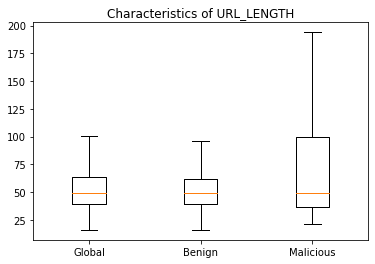

In [77]:
auto_boxplot(data, "URL_LENGTH", False)

We see that Malicious website tend to have a longer URL value than benign website; hence, it is relevant to keep this column.

### Column 3 : NUMBER_SPECIAL_CHARACTERS

This column describes the number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”

In [78]:
spec_chars = data["NUMBER_SPECIAL_CHARACTERS"].copy()
print(spec_chars.head())
print("Length :", len(spec_chars))

0    6
1    6
2    6
3    6
4    7
Name: NUMBER_SPECIAL_CHARACTERS, dtype: int64
Length : 1431


In [79]:
print(spec_chars.describe())

count    1431.000000
mean       10.462614
std         3.536399
min         6.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        31.000000
Name: NUMBER_SPECIAL_CHARACTERS, dtype: float64


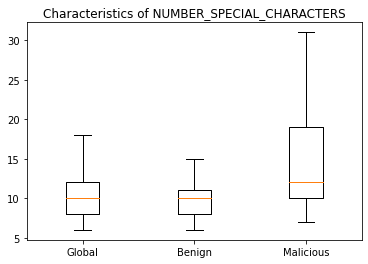

In [80]:
auto_boxplot(data, "NUMBER_SPECIAL_CHARACTERS", False)

We see that Malicious website's URL contain more special characters than benign website. It is relevant to keep this column for our study.

### Column 6 : Content length

This column gives the content size of the HTTP header

In [81]:
cont_len = data["CONTENT_LENGTH"].copy()
print(cont_len.head())
print("Length :", len(cont_len))

0    15087.000000
1      324.000000
2      162.000000
3     5305.320635
4     5305.000000
Name: CONTENT_LENGTH, dtype: float64
Length : 1431


In [82]:
print(cont_len.describe())

count     1431.000000
mean      4834.664486
std       4660.238549
min          9.000000
25%        970.000000
50%       5305.000000
75%       5305.000000
max      30285.000000
Name: CONTENT_LENGTH, dtype: float64


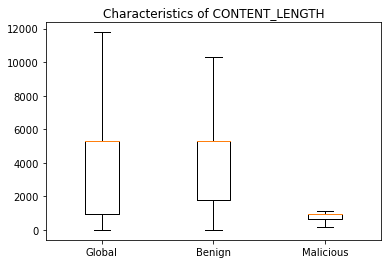

In [83]:
auto_boxplot(data, "CONTENT_LENGTH", False)

We see that the content length for Malicious websites is very low compared to benign websites. It is relevant to keep this column for our study.

### Column 8 : WHOIS_REGDATE

This column provides the server registration date ; initially, it was in a date format, however, we transformed it into a numeric value as explained before

In [84]:
regdate = data["WHOIS_REGDATE"].copy()
print(regdate.head())
print("Length :", len(regdate))

0     958191896.0
1     958191896.0
2     868500000.0
3     849740400.0
4    1457443800.0
Name: WHOIS_REGDATE, dtype: object
Length : 1431


In [85]:
print(regdate.describe())

count          1431.0
unique          768.0
top       979341120.0
freq             59.0
Name: WHOIS_REGDATE, dtype: float64


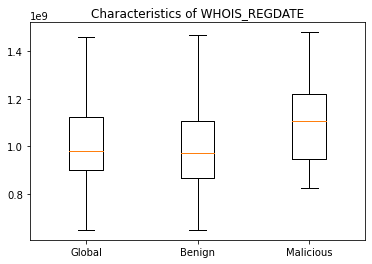

In [86]:
auto_boxplot(data, "WHOIS_REGDATE", False)

We see that the WHOIS registration date for Malicious websites tends to be more recent than the one for benign websites. It is relevant to keep this column for our study.

### Column 9 : WHOIS_UPDATED_DATE

This column provides the server update date ; initially, it was in a date format, however, we transformed it into a numeric value as explained before

In [87]:
updates = data["WHOIS_UPDATED_DATE"].copy()
print(updates.head())
print("Length :", len(updates))

0    1392814909.0
1    1392814909.0
2    1386546300.0
3    1509750000.0
4    1457577900.0
Name: WHOIS_UPDATED_DATE, dtype: object
Length : 1431


In [88]:
print(updates.describe())

count     1.431000e+03
unique    5.430000e+02
top       1.449912e+09
freq      5.900000e+01
Name: WHOIS_UPDATED_DATE, dtype: float64


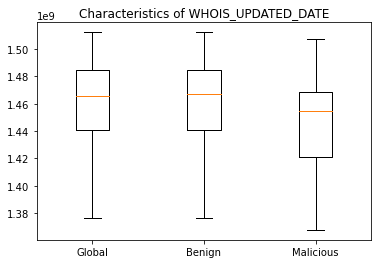

In [89]:
auto_boxplot(data, "WHOIS_UPDATED_DATE", False)

We see that the WHOIS updated date for Malicious websites tends to be more concentrated around a certain value than the one for benign websites. It is relevant to keep this column for our study.

### Column 10 : TCP_CONVERSATION_EXCHANGE

This column describes the number of TCP packets exchanged between the server and the client

In [90]:
tcpconv = data["TCP_CONVERSATION_EXCHANGE"].copy()
print(tcpconv.head())
print("Length :", len(tcpconv))

0    17
1    11
2    31
3    57
4    11
Name: TCP_CONVERSATION_EXCHANGE, dtype: int64
Length : 1431


In [91]:
print(tcpconv.describe())

count    1431.000000
mean       15.551363
std        10.875261
min         1.000000
25%        11.000000
50%        11.000000
75%        19.000000
max        57.000000
Name: TCP_CONVERSATION_EXCHANGE, dtype: float64


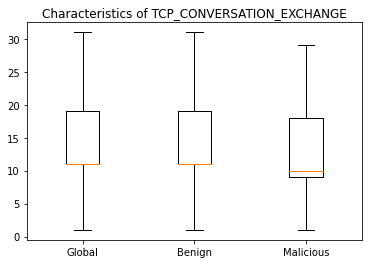

In [92]:
auto_boxplot(data, "TCP_CONVERSATION_EXCHANGE", False)

The number of packets exchange doens't change according to if it is a malicious site or a benign site, we can ignore this column.

### Column 11 : DIST_REMOTE_TCP_PORT

This column describes the number of the ports detected and different to TCP

In [93]:
nbports = data["DIST_REMOTE_TCP_PORT"].copy()
print(nbports.head())
print("Length :", len(nbports))

0    7
1    2
2    2
3    2
4    6
Name: DIST_REMOTE_TCP_PORT, dtype: int64
Length : 1431


In [94]:
print(nbports.describe())

count    1431.000000
mean        2.936408
std         2.682397
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: DIST_REMOTE_TCP_PORT, dtype: float64


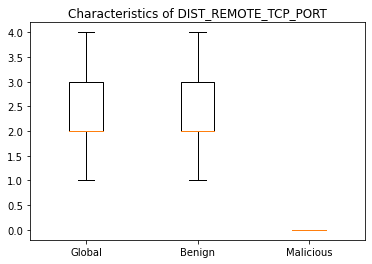

In [95]:
auto_boxplot(data, "DIST_REMOTE_TCP_PORT", False)

It looks like Malicious website only use TCP port. This column is relevant to keep.

### Column 12 : REMOTE_IPS

This column describes the total number of IPs connected to the honeypot

In [96]:
nbips = data["REMOTE_IPS"].copy()
print(nbips.head())
print("Length :", len(nbips))

0    4
1    2
2    3
3    5
4    9
Name: REMOTE_IPS, dtype: int64
Length : 1431


In [97]:
print(nbips.describe())

count    1431.000000
mean        3.626834
std         2.503526
min         1.000000
25%         2.000000
50%         2.000000
75%         5.000000
max        12.000000
Name: REMOTE_IPS, dtype: float64


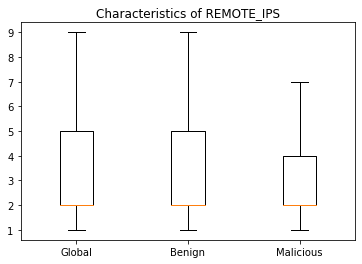

In [98]:
auto_boxplot(data, "REMOTE_IPS", False)

There is a small difference between Malicious and Benign website for this criteria, we can keep it.

### Column 13 : APP_BYTES

This column describes the number of bytes transferred

In [99]:
nbytes = data["APP_BYTES"].copy()
print(nbytes.head())
print("Length :", len(nbytes))

0    1230
1    1237
2    3812
3    4278
4     894
Name: APP_BYTES, dtype: int64
Length : 1431


In [100]:
print(nbytes.describe())

count    1431.000000
mean     1687.530398
std      1200.421058
min        54.000000
25%      1237.000000
50%      1237.000000
75%      1970.000000
max      6078.000000
Name: APP_BYTES, dtype: float64


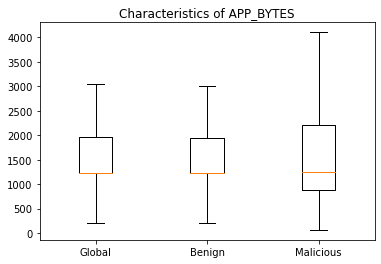

In [101]:
auto_boxplot(data, "APP_BYTES", False)

These data are slightly different according to their type, we can keep the column.

### Column 14 : SOURCE_APP_PACKETS

This column gives the number of packets sent to the server

In [102]:
npacket = data["SOURCE_APP_PACKETS"].copy()
print(npacket.head())
print("Length :", len(npacket))

0    17
1    13
2    39
3    61
4    11
Name: SOURCE_APP_PACKETS, dtype: int64
Length : 1431


In [103]:
print(npacket.describe())

count    1431.000000
mean       18.638015
std        12.750332
min         1.000000
25%        13.000000
50%        13.000000
75%        23.000000
max        68.000000
Name: SOURCE_APP_PACKETS, dtype: float64


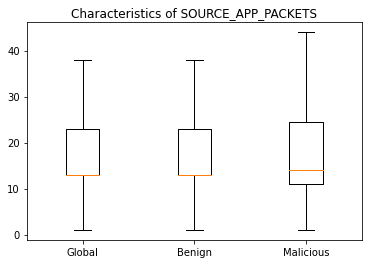

In [104]:
auto_boxplot(data,"SOURCE_APP_PACKETS", False )

There only is a small difference between malicious and benign websites for this criteria. We can ignore it.

### Column 15 : REMOTE_APP_PACKETS

This column indicates the number of packets received by the server

In [105]:
nreceivedpack = data["REMOTE_APP_PACKETS"].copy()
print(nreceivedpack.head())
print("Length :", len(nreceivedpack))

0    19
1    13
2    37
3    62
4    13
Name: REMOTE_APP_PACKETS, dtype: int64
Length : 1431


In [106]:
print(nreceivedpack.describe())

count    1431.000000
mean       17.670161
std        12.277283
min         2.000000
25%        13.000000
50%        13.000000
75%        22.000000
max        65.000000
Name: REMOTE_APP_PACKETS, dtype: float64


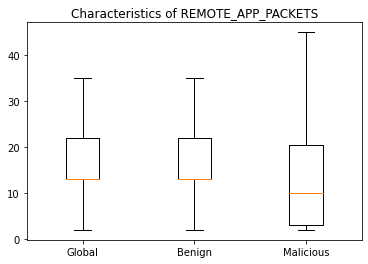

In [107]:
auto_boxplot(data, "REMOTE_APP_PACKETS", False)

There is a huge difference in the repartition of this value depending on if it is a malicious website or a benign website. Hence, this column is relevant for our study, we will keep it.

### Column 16 : SOURCE_APP_BYTES

This column describes the total number of IPs connected to the honeypot

In [108]:
nbips = data["SOURCE_APP_BYTES"].copy()
print(nbips.head())
print("Length :", len(nbips))

0     1265
1     3524
2    18784
3     3524
4      838
Name: SOURCE_APP_BYTES, dtype: int64
Length : 1431


In [109]:
print(nbips.describe())

count     1431.000000
mean      4470.861635
std       5517.735018
min        124.000000
25%       1420.500000
50%       3524.000000
75%       3524.000000
max      30057.000000
Name: SOURCE_APP_BYTES, dtype: float64


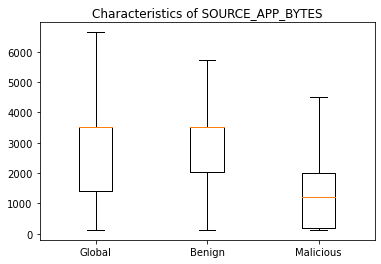

In [110]:
auto_boxplot(data, "SOURCE_APP_BYTES", False)

There is a huge difference between Malicious and Benign website for this criteria, we can keep it.

### Column 17 : REMOTE_APP_BYTES

This column describes the number of bytes received by the server

In [111]:
nappreceived = data["REMOTE_APP_BYTES"].copy()
print(nappreceived.head())
print("Length :", len(nappreceived))

0    1230
1    1436
2    4380
3    4586
4     894
Name: REMOTE_APP_BYTES, dtype: int64
Length : 1431


In [112]:
print(nappreceived.describe())

count    1431.000000
mean     1959.674354
std      1385.492169
min        54.000000
25%      1436.000000
50%      1436.000000
75%      2388.000000
max      6945.000000
Name: REMOTE_APP_BYTES, dtype: float64


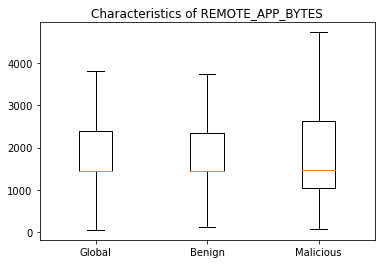

In [113]:
auto_boxplot(data, "REMOTE_APP_BYTES", False)

There isn't a clear difference for the repartition of this value depending on if it's a malicious website or not ; hence, we can delete this column.

### Column 17 : APP_PACKETS

This column corresponds to the total number of IP packets generated during the communication between the honeypot and the server

In [114]:
napp = data["APP_PACKETS"].copy()
print(napp.head())
print("Length :", len(napp))

0    17
1    13
2    39
3    61
4    11
Name: APP_PACKETS, dtype: int64
Length : 1431


In [115]:
print(napp.describe())

count    1431.000000
mean       18.638015
std        12.750332
min         1.000000
25%        13.000000
50%        13.000000
75%        23.000000
max        68.000000
Name: APP_PACKETS, dtype: float64


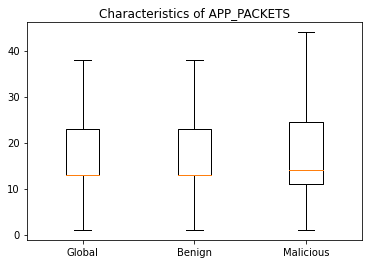

In [116]:
auto_boxplot(data, "APP_PACKETS", False)

There isn't a clear difference for the repartition of this value depending on if it's a malicious website or not ; hence, we can delete this column.

### Column 18 : DNS_QUERY_TIMES

 This column refers to the number of DNS packets generated during the communication between the honeypot and the server

In [117]:
query_time = data["DNS_QUERY_TIMES"].copy()
print(query_time.head())
print("Length :", len(query_time))

0    0.0
1    0.0
2    8.0
3    4.0
4    0.0
Name: DNS_QUERY_TIMES, dtype: float64
Length : 1431


In [118]:
print(query_time.describe())

count    1431.000000
mean        2.214119
std         2.789038
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max        10.000000
Name: DNS_QUERY_TIMES, dtype: float64


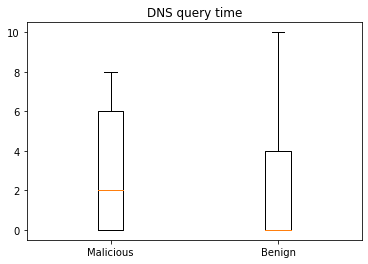

In [119]:
query_time_m = data.loc[csv["Type"]==1]["DNS_QUERY_TIMES"] # Malicious tcp packets
query_time_b = data.loc[csv["Type"]==0]["DNS_QUERY_TIMES"] # Benign tcp packets

plt.figure()
plt.title("DNS query time")

plt.boxplot([query_time_m, query_time_b], labels =["Malicious", "Benign"], showfliers = False)
plt.show()


Malicious website tend to generate more DNS packet than benign site, hence, we will keep this column for our prediction.

## One-Hot Encoding of categorical data

We now can one-hot encode the columns without any difficulty.

#### Example with Charsets

In [120]:
# Creating an array containing all the possible values in the string fields
poss = np.unique(data['CHARSET'].to_numpy())

In [121]:
from tensorflow.keras.utils import to_categorical
charset_map = {} # Dictionary to keep the "real" values

values = []
# We first create an ordinal array with all the values
for i, el in enumerate(poss):
    values.append(i)
print("Ordinal array :", values)
        
# We then convert it to one-hot     
one_hot = to_categorical(values)
print("\nOne hot :", one_hot)
        
for i, el in enumerate(poss): 
    charset_map[el] = np.array(one_hot[i])

print("\nDictionary :", charset_map)

Ordinal array : [0, 1, 2]

One hot : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Dictionary : {'iso-8859': array([1., 0., 0.], dtype=float32), 'us-ascii': array([0., 1., 0.], dtype=float32), 'utf-8': array([0., 0., 1.], dtype=float32)}


#### Application

Let's create a function which we can use later to convert our categorical data into one-hot envoded data.

In [122]:
def onehot_dict(data):
    poss = np.unique(np.array(data))
    field_map = {} # Dictionary to keep the "real" values

    values = []
    # We first create an ordinal array with all the values
    for i, el in enumerate(poss):
        values.append(i)
   
    # We then convert it to one-hot     
    one_hot = to_categorical(values)
   

    for i, el in enumerate(poss): 
        field_map[el] = np.array(one_hot[i])
    
    return field_map

We convert all the values in the column into one-hot encoded values

In [123]:
def onehot_conv(data, columns):
    mapping = {} # General dictionary for all the categories
    res = data.copy()

    for el in columns:
        mapping[el] = onehot_dict(res[el])

    for el in columns:
        for index, row in res[el].to_frame().iterrows():
            res.at[index, el] = mapping[el][row[el]]
        
    return mapping, res

  
    



In [124]:
columns = ['CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO']
mapping, new_data = onehot_conv(data, columns)

We have successfully created our one-hot encoded version :

In [125]:
new_data

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2314,16,6,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15087.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",958191896.0,1392814909.0,...,7,4,1230,17,19,1265,1230,17,0.0,0
1,B0_911,16,6,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",324.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",958191896.0,1392814909.0,...,2,2,1237,13,13,3524,1436,13,0.0,0
2,B0_113,17,6,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",162.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",868500000.0,1386546300.0,...,2,3,3812,39,37,18784,4380,39,8.0,0
3,B0_403,17,6,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5305.320635,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",849740400.0,1509750000.0,...,2,5,4278,61,62,3524,4586,61,4.0,0
4,B0_2064,18,7,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5305.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1457443800.0,1457577900.0,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,M4_45,194,17,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",970.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1427,M4_48,194,16,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",970.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1221602400.0,1454972400.0,...,0,2,1257,14,3,186,1470,14,0.0,1
1428,B0_162,52,10,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",8904.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",919033200.0,1436911200.0,...,2,6,1237,13,13,3524,6945,13,4.0,0
1429,B0_1152,52,10,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5305.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",883868400.0,1473631200.0,...,2,2,1237,13,13,3524,1436,13,0.0,0


In [126]:
data = new_data.copy()

## Selecting useful columns

As we have seen above, some columns should be deleted as they are not very useful to predict the type of the website.

In [127]:
data.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [128]:
col2delete = ['URL', 'CHARSET', 'TCP_CONVERSATION_EXCHANGE', 'SOURCE_APP_PACKETS', 'REMOTE_APP_BYTES', 'APP_PACKETS']

In [129]:
final_data = data.copy()

In [130]:
data = final_data.drop(columns=col2delete).copy()

# II - Predictive models

In [131]:
data

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,16,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15087.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",958191896.0,1392814909.0,7,4,1230,19,1265,0.0,0
1,16,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",324.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",958191896.0,1392814909.0,2,2,1237,13,3524,0.0,0
2,17,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",162.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",868500000.0,1386546300.0,2,3,3812,37,18784,8.0,0
3,17,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5305.320635,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",849740400.0,1509750000.0,2,5,4278,62,3524,4.0,0
4,18,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5305.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1457443800.0,1457577900.0,6,9,894,13,838,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,194,17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",970.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1221602400.0,1454972400.0,0,2,1257,3,186,0.0,1
1427,194,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",970.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1221602400.0,1454972400.0,0,2,1257,3,186,0.0,1
1428,52,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",8904.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",919033200.0,1436911200.0,2,6,1237,13,3524,4.0,0
1429,52,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5305.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",883868400.0,1473631200.0,2,2,1237,13,3524,0.0,0


In [132]:
X = data.copy().drop(columns=["Type"]).values.tolist()
y = data.copy()["Type"]

We need to put each row into a single list to input it to a model.

In [133]:
new_X = []
for row in X:
    new_row = []
    for el in row:
        if type(el) == type(np.array([])) :
            for subel in el:
                new_row.append(subel)
        else:
            new_row.append(el)
    new_X.append(np.array(new_row))
    
new_X = np.array(new_X)

Let's create a function that return the test accuracy over n tries using cross-validation.

In [134]:
from sklearn.model_selection import train_test_split
def n_tries(model, X, y, n):
    n_accuracies = 0
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
        model.fit(X_train, y_train)
        n_accuracies += model.score(X_test, y_test)
    return n_accuracies/n

## A - Logistic Regression

Let's start by the simplest model of classification : logistic regression.

In [135]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)

In [136]:
n_tries(LR, new_X, y, 100)

0.8811416490486259

## B - KNN Classification

The clear seperation between malicious and benign websites makes our data nonlinear
Hence, KNN is an easy and efficient algorithm to use, although it costs a lot of time and memory

KNN chooses N neighbours, calculates the distance to each of them, takes the n nearest neighboor and classify
the item at stake according to the most represented categories among these neighbours

In [137]:
from sklearn.neighbors import KNeighborsClassifier


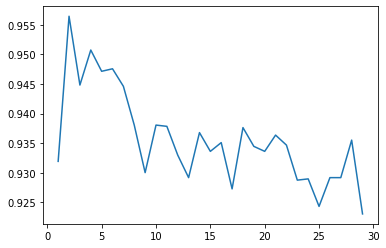

In [164]:
lst = []
acc = []
for k in range(1,30):
    KNN = KNeighborsClassifier(n_neighbors=k)
    acc.append(n_tries(KNN, new_X, y, 10))
    lst.append(k)
    
plt.plot(lst, acc)

We get a great accuracy with k = 3.

In [165]:
KNN = KNeighborsClassifier(n_neighbors=3)
n_tries(KNN, new_X, y, 10)

0.9395348837209303

## C - Linear Discriminant Analysis

Malicious and Benign websites are well-separated with the columns we kept.
Hence, as we have seen during our lecture, the parameter estimated for the logistic regression model are unstable.
That's why we prefer using Linear discriminant analysis.

In [174]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()

In [175]:
n_tries(LDA, new_X,y, 10)

0.9676532769556024

We get pretty good accuracy with Linear Discriminant Analysis. It is our best model so far, and compute faster than KNN !

## D - Dense Neural Networks

<img style="height:300px;" src= "https://miro.medium.com/max/1400/1*XPThP6QC5VkeG3VzI0FhIQ.png">

We can try to use Neural Networks to predict the type of a website. Neural networks are composed of layers of interconnected neurons that perform very simple linear combinations. Overall, this technique can make prediction over a huge number of data and is often used nowadays.

In [139]:
import matplotlib.pyplot as plt
def show_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print("Train accuracy :", history.history['acc'][-1])
    print("Test accuracy  :", history.history['val_acc'][-1])
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'm', label='Testing acc')
    plt.title('Training and testing accuracy')
    plt.legend()

    plt.figure()
    
    
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'm', label='Testing loss')
    plt.title('Training and test loss')
    plt.legend()

    plt.show()
    
    

Train accuracy : 0.8810020685195923
Test accuracy  : 0.9048625826835632


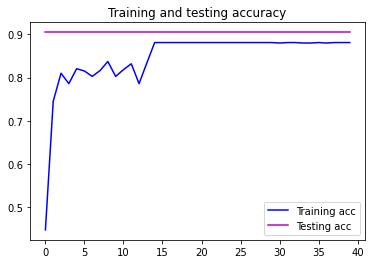

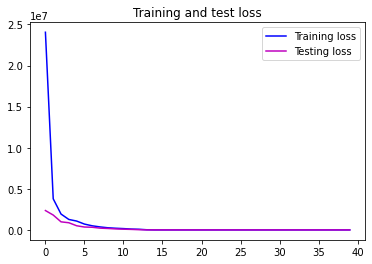

In [140]:
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf

train, test, train_labels, test_labels = train_test_split(new_X, to_categorical(y), test_size=0.33, shuffle=True)

model = models.Sequential()
model.add(layers.Flatten())

model.add(layers.Dense(8,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dropout(.2)) # Regularisation by dropout to reduce overfitting
    
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(2,activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) 
# binary_crossentropy is caracteristic to binary classifications

    
    
# On entraîne le modèle sur les données précedemment prétraitées 
# et on teste les performances du modèle sur le batch de test. 
history = model.fit(train, train_labels, epochs = 40, 
                        validation_data=(test, test_labels), 
                        verbose=0, #On masque les progress bars
                        )
                        
show_acc(history)

As we can see, using neural networks is maybe not the best way to predict the type of the website here. Indeed, it takes a long time to train this type of model. Furthermore, the accuracy is not really outstanding. LDA did a better job on this.

### => We keep LDA as our model, it did the better job and compute in a little time compared to KNN or NN.

In [189]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()
model.fit(new_X, y)

LinearDiscriminantAnalysis()

# III - Preprocessing the test set

The test set is printed below

In [141]:
csv_test

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M4_22,100,20,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1,B0_402,50,11,ISO-8859-1,None,1819.0,US,CA,2/11/2002 0:00,2/02/2017 0:00,...,27,5,5203,41,44,13097,5803,41,8.0,0
2,B0_438,28,7,UTF-8,GSE,6666.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,11,6311,70,64,63634,6633,70,4.0,0
3,B0_759,43,7,UTF-8,GSE,20592.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,13,6081,69,71,63457,6463,69,4.0,0
4,B0_280,47,11,utf-8,Apache/2.2.15 (Red Hat),NaN,None,None,None,None,...,1,7,1552,21,20,2790,2000,21,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,B0_583,141,24,UTF-8,ATS,NaN,US,CA,18/01/1995 0:00,26/08/2015 0:00,...,7,6,3925,39,35,21489,4535,39,8.0,0
346,M0_99,48,14,UTF-8,Apache,NaN,CZ,PRAHA,7/10/2006 0:00,7/03/2017 0:00,...,0,1,3450,50,51,66124,3602,50,2.0,1
347,B0_2224,25,6,UTF-8,LiteSpeed,NaN,None,None,27/01/2005 0:00,15/11/2013 0:00,...,5,2,564,6,7,442,564,6,0.0,0
348,B0_494,88,15,UTF-8,Apache,NaN,None,None,25/03/2010 0:00,25/03/2017 0:00,...,3,4,1346,15,16,1725,1670,15,4.0,0


### In our analysis, we decided that the following columns could be ignored

'URL', 
'CHARSET', 
'TCP_CONVERSATION_EXCHANGE', 
'SOURCE_APP_PACKETS', 
'REMOTE_APP_BYTES', 
'APP_PACKETS'

Let's create a copy of our test set without these columns

In [142]:
test_nan=csv_test.copy()

In [143]:
todrop=['URL','CHARSET','TCP_CONVERSATION_EXCHANGE','SOURCE_APP_PACKETS','REMOTE_APP_BYTES','APP_PACKETS']
test_nan=test_nan.drop(columns=todrop)
print(len(test_nan.columns))
print(len(csv_test.columns))

15
21


Our columns have been succesfully deleted. Among the remaining columns, let's see how many numerical column we have

In [144]:
# Getting the numerical columns
from pandas.api.types import is_numeric_dtype
num_col_test = []

for el in test_nan.columns:
    if is_numeric_dtype(test_nan[el]):
        num_col_test.append(el)
print(len(num_col_test))

10


#### Processing numerical columns

In [145]:
import math
def correct_nan_test(data, column):
    count = 0
    for index, row in data.iterrows():    
        x = row[column]
        
        if math.isnan(x) or x==0:
            count += 1
            data.at[index,column]= data[column].mean()

    print("Done on", str(column) + ".", count, "nan processed.")
    return data

We will apply this process on all the numerical columns of our test set except the Type column

In [146]:
for el in num_col_test:
    if (el != "Type"):
        test_nan = correct_nan_test(test_nan, el)  
        
test_nan.head

Done on URL_LENGTH. 0 nan processed.
Done on NUMBER_SPECIAL_CHARACTERS. 0 nan processed.
Done on CONTENT_LENGTH. 169 nan processed.
Done on DIST_REMOTE_TCP_PORT. 189 nan processed.
Done on REMOTE_IPS. 140 nan processed.
Done on APP_BYTES. 140 nan processed.
Done on REMOTE_APP_PACKETS. 116 nan processed.
Done on SOURCE_APP_BYTES. 116 nan processed.
Done on DNS_QUERY_TIMES. 203 nan processed.


<bound method NDFrame.head of      URL_LENGTH  NUMBER_SPECIAL_CHARACTERS                   SERVER  \
0           100                         20                   Apache   
1            50                         11                     None   
2            28                          7                      GSE   
3            43                          7                      GSE   
4            47                         11  Apache/2.2.15 (Red Hat)   
..          ...                        ...                      ...   
345         141                         24                      ATS   
346          48                         14                   Apache   
347          25                          6                LiteSpeed   
348          88                         15                   Apache   
349          47                          9                     None   

     CONTENT_LENGTH WHOIS_COUNTRY WHOIS_STATEPRO    WHOIS_REGDATE  \
0      15319.311475            ES      Barcelona

#### Processing categorical values

The following functions will be useful to process our categorical columns.

In [147]:
""" The function below returns, for a given categorical column, the list of the most repeated value 
no matter if it is malicious or benign"""
def mostrepeatedtest(data, column,n):
    value=data[column].value_counts()[:n].index.tolist()
    return value
   
""" The function below replaces the None of a column for which we calculated the most repeated value 
beforehand thanks to the previous function"""
def correct_Nonetest(data, column,value):
    count=0
    if(value[0]=='None' or value[0]=='none'):
        most_freq=value[1]
    else:
        most_freq=value[0]
    
    for index, row in data.iterrows():
        x = row[column]
        if x=='None'or x=='none':
            count= count+1
            data.at[index,column]= most_freq
    print("Done on ", str(column) + ".", count, " None processed." )
    return data

Let's recall which are our categorical columns :

In [148]:
# Visualizing all the categorical columns
cat_col_test = []
for el in test_nan.columns:
    if is_numeric_dtype(test_nan[el])==False:
        cat_col_test.append(el)  
print(cat_col_test)

['SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']


#### Column Server

In [149]:
Servertest = csv_test["SERVER"].copy()
print(Servertest)

0                       Apache
1                         None
2                          GSE
3                          GSE
4      Apache/2.2.15 (Red Hat)
                ...           
345                        ATS
346                     Apache
347                  LiteSpeed
348                     Apache
349                       None
Name: SERVER, Length: 350, dtype: object


In [150]:
columnserver(test_nan)['SERVER']

0         Apache
1           None
2            GSE
3            GSE
4         Apache
         ...    
345          ATS
346       Apache
347    LiteSpeed
348       Apache
349         None
Name: SERVER, Length: 350, dtype: object

In [151]:
filler=mostrepeatedtest(test_nan,'SERVER',2)
test_nan = correct_Nonetest(test_nan, 'SERVER',filler) 
test_nan['SERVER'].head

Done on  SERVER. 47  None processed.


<bound method NDFrame.head of 0         Apache
1         Apache
2            GSE
3            GSE
4         Apache
         ...    
345          ATS
346       Apache
347    LiteSpeed
348       Apache
349       Apache
Name: SERVER, Length: 350, dtype: object>

#### Column WHOIS_COUNTRY

In [152]:
Whoiscountry = csv_test["WHOIS_COUNTRY"].copy()
print(Whoiscountry)

0        ES
1        US
2        US
3        US
4      None
       ... 
345      US
346      CZ
347    None
348    None
349      US
Name: WHOIS_COUNTRY, Length: 350, dtype: object


We prepocess our column thanks to the function we created for our model's preprocessing

In [153]:
columncountries(test_nan)['WHOIS_COUNTRY']

0        ES
1        US
2        US
3        US
4      None
       ... 
345      US
346      CZ
347    None
348    None
349      US
Name: WHOIS_COUNTRY, Length: 350, dtype: object

We fill all the None with the most repeated value of our test set

In [154]:
filler=mostrepeatedtest(test_nan,'WHOIS_COUNTRY',2)
test_nan = correct_Nonetest(test_nan, 'WHOIS_COUNTRY',filler) 
test_nan['WHOIS_COUNTRY'].head

Done on  WHOIS_COUNTRY. 95  None processed.


<bound method NDFrame.head of 0      ES
1      US
2      US
3      US
4      US
       ..
345    US
346    CZ
347    US
348    US
349    US
Name: WHOIS_COUNTRY, Length: 350, dtype: object>

#### Column WHOIS_STATEPRO

In [155]:
Whoistate = csv_test["WHOIS_STATEPRO"].copy()
print(Whoistate)

0       Barcelona
1              CA
2              CA
3              CA
4            None
          ...    
345            CA
346         PRAHA
347          None
348          None
349    California
Name: WHOIS_STATEPRO, Length: 350, dtype: object


We prepocess our column thanks to the function we created for our model's preprocessing

In [156]:
columnstatepro(test_nan)['WHOIS_STATEPRO']

0       BARCELONA
1              CA
2              CA
3              CA
4            None
          ...    
345            CA
346         PRAHA
347          None
348          None
349    CALIFORNIA
Name: WHOIS_STATEPRO, Length: 350, dtype: object

We fill all the None with the most repeated value of our test set

In [157]:
filler=mostrepeatedtest(test_nan,'WHOIS_STATEPRO',2)
test_nan = correct_Nonetest(test_nan, 'WHOIS_STATEPRO',filler) 
test_nan['WHOIS_STATEPRO'].head

Done on  WHOIS_STATEPRO. 102  None processed.


<bound method NDFrame.head of 0       Barcelona
1              CA
2              CA
3              CA
4              CA
          ...    
345            CA
346         PRAHA
347            CA
348            CA
349    California
Name: WHOIS_STATEPRO, Length: 350, dtype: object>

#### Column WHOIS_REGDATE' and 'WHOIS_UPDATED_DATE'

In [158]:
test_nan['WHOIS_REGDATE']

0      17/09/2008 0:00
1       2/11/2002 0:00
2      31/07/2000 0:00
3      31/07/2000 0:00
4                 None
            ...       
345    18/01/1995 0:00
346     7/10/2006 0:00
347    27/01/2005 0:00
348    25/03/2010 0:00
349    28/11/1999 0:00
Name: WHOIS_REGDATE, Length: 350, dtype: object

For these 2 columns, we will transform dates into floats so that we will treat it like numerical columns

In [159]:
for index, row in test_nan.iterrows():
    x = row["WHOIS_REGDATE"]
    if x!="None":
        test_nan.loc[index, "WHOIS_REGDATE"] = date2float(x)
    else:
        test_nan.loc[index, "WHOIS_REGDATE"] = 0.0
        
    x = row["WHOIS_UPDATED_DATE"]
    if x!="None":
        test_nan.loc[index, "WHOIS_UPDATED_DATE"] = date2float(x)
    
    else:
        test_nan.loc[index, "WHOIS_UPDATED_DATE"] = 0.0

In [160]:
test_nan['WHOIS_REGDATE']

0      1221602400.0
1      1013382000.0
2       964994400.0
3       964994400.0
4               0.0
           ...     
345     790383600.0
346    1152482400.0
347    1106780400.0
348    1269471600.0
349     943743600.0
Name: WHOIS_REGDATE, Length: 350, dtype: object

Dates are now floats, we can fix the none just like for a numerical value

In [161]:
test_nan = correct_nan_test(test_nan, 'WHOIS_REGDATE')
test_nan = correct_nan_test(test_nan, 'WHOIS_UPDATED_DATE')

Done on WHOIS_REGDATE. 38 nan processed.
Done on WHOIS_UPDATED_DATE. 43 nan processed.


In [162]:
test_nan

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,100,20,Apache,15319.311475,ES,Barcelona,1221602400.0,1454972400.0,4,3,1873,3,186,2.171429,1
1,50,11,Apache,1819.000000,US,CA,1013382000.0,1485990000.0,27,5,5203,44,13097,8.000000,0
2,28,7,GSE,6666.000000,US,CA,964994400.0,1467151200.0,5,11,6311,64,63634,4.000000,0
3,43,7,GSE,20592.000000,US,CA,964994400.0,1467151200.0,5,13,6081,71,63457,4.000000,0
4,47,11,Apache,15319.311475,US,CA,896780723.657143,1277948428.457143,1,7,1552,20,2790,6.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,141,24,ATS,15428.926706,US,CA,790383600.0,1440540000.0,7,6,3925,35,21489,8.000000,0
346,48,14,Apache,15428.926706,CZ,PRAHA,1152482400.0,1499032800.0,7,1,3450,51,66124,2.000000,1
347,25,6,LiteSpeed,15428.926706,US,CA,1106780400.0,1384470000.0,5,2,564,7,442,3.853000,0
348,88,15,Apache,15428.926706,US,CA,1269471600.0,1490396400.0,3,4,1346,16,1725,4.000000,0


## One-Hot Encoding of categorical data

We now can one-hot encode the columns without any difficulty.

#### Application

Let's create a function which we can use later to convert our categorical data into one-hot envoded data.

We convert all the values in the column into one-hot encoded values

In [180]:
def onehot_conv_test(data, columns, mapping):
    res = data.copy()


    for el in columns:
        for index, row in res[el].to_frame().iterrows():
            res.at[index, el] = mapping[el][row[el]]
        
    return res

In [182]:
columns = ['SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO']
new_data = onehot_conv_test(test_nan, columns, mapping)

We have successfully created our one-hot encoded version :

In [183]:
new_data

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,100,20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15319.311475,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1221602400.0,1454972400.0,4,3,1873,3,186,2.171429,1
1,50,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1819.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1013382000.0,1485990000.0,27,5,5203,44,13097,8.000000,0
2,28,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6666.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",964994400.0,1467151200.0,5,11,6311,64,63634,4.000000,0
3,43,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20592.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",964994400.0,1467151200.0,5,13,6081,71,63457,4.000000,0
4,47,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15319.311475,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",896780723.657143,1277948428.457143,1,7,1552,20,2790,6.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,141,24,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15428.926706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",790383600.0,1440540000.0,7,6,3925,35,21489,8.000000,0
346,48,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15428.926706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1152482400.0,1499032800.0,7,1,3450,51,66124,2.000000,1
347,25,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15428.926706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1106780400.0,1384470000.0,5,2,564,7,442,3.853000,0
348,88,15,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",15428.926706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1269471600.0,1490396400.0,3,4,1346,16,1725,4.000000,0


In [184]:
data_test = new_data.copy()

In [190]:
X_test = data_test.copy().drop(columns=["Type"]).values.tolist()
y_test = data_test["Type"]

We need to put each row into a single list to input it to a model.

In [191]:
new_X_test = []
for row in X_test:
    new_row = []
    for el in row:
        if type(el) == type(np.array([])) :
            for subel in el:
                new_row.append(subel)
        else:
            new_row.append(el)
    new_X_test.append(np.array(new_row))
    
new_X_test = np.array(new_X_test)

In [193]:
model.score(new_X_test, y_test)

0.9114285714285715

In [195]:
model.predict(new_X_test)

350

In [197]:
test_csv = pd.read_csv("test.csv")

In [198]:
test_csv

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,M4_22,100,20,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0
1,B0_402,50,11,ISO-8859-1,None,1819.0,US,CA,2/11/2002 0:00,2/02/2017 0:00,33,27,5,5203,41,44,13097,5803,41,8.0
2,B0_438,28,7,UTF-8,GSE,6666.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,66,5,11,6311,70,64,63634,6633,70,4.0
3,B0_759,43,7,UTF-8,GSE,20592.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,64,5,13,6081,69,71,63457,6463,69,4.0
4,B0_280,47,11,utf-8,Apache/2.2.15 (Red Hat),NaN,None,None,None,None,15,1,7,1552,21,20,2790,2000,21,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,B0_583,141,24,UTF-8,ATS,NaN,US,CA,18/01/1995 0:00,26/08/2015 0:00,31,7,6,3925,39,35,21489,4535,39,8.0
346,M0_99,48,14,UTF-8,Apache,NaN,CZ,PRAHA,7/10/2006 0:00,7/03/2017 0:00,48,0,1,3450,50,51,66124,3602,50,2.0
347,B0_2224,25,6,UTF-8,LiteSpeed,NaN,None,None,27/01/2005 0:00,15/11/2013 0:00,6,5,2,564,6,7,442,564,6,0.0
348,B0_494,88,15,UTF-8,Apache,NaN,None,None,25/03/2010 0:00,25/03/2017 0:00,11,3,4,1346,15,16,1725,1670,15,4.0


In [199]:
test_csv["Type"] = model.predict(new_X_test)

In [200]:
test_csv

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M4_22,100,20,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1,B0_402,50,11,ISO-8859-1,None,1819.0,US,CA,2/11/2002 0:00,2/02/2017 0:00,...,27,5,5203,41,44,13097,5803,41,8.0,0
2,B0_438,28,7,UTF-8,GSE,6666.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,11,6311,70,64,63634,6633,70,4.0,0
3,B0_759,43,7,UTF-8,GSE,20592.0,US,CA,31/07/2000 0:00,29/06/2016 0:00,...,5,13,6081,69,71,63457,6463,69,4.0,0
4,B0_280,47,11,utf-8,Apache/2.2.15 (Red Hat),NaN,None,None,None,None,...,1,7,1552,21,20,2790,2000,21,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,B0_583,141,24,UTF-8,ATS,NaN,US,CA,18/01/1995 0:00,26/08/2015 0:00,...,7,6,3925,39,35,21489,4535,39,8.0,0
346,M0_99,48,14,UTF-8,Apache,NaN,CZ,PRAHA,7/10/2006 0:00,7/03/2017 0:00,...,0,1,3450,50,51,66124,3602,50,2.0,1
347,B0_2224,25,6,UTF-8,LiteSpeed,NaN,None,None,27/01/2005 0:00,15/11/2013 0:00,...,5,2,564,6,7,442,564,6,0.0,0
348,B0_494,88,15,UTF-8,Apache,NaN,None,None,25/03/2010 0:00,25/03/2017 0:00,...,3,4,1346,15,16,1725,1670,15,4.0,0


In [202]:
test_csv.to_csv('predict.csv', index=False)